In [214]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.metrics import accuracy_score
import yfinance as yf

In [102]:
# Cell 1
# Brownian motion example

# Brownian motion simulator
def GBM(T=1.0, n=1000):
    delta_t = T / n
    t = np.linspace(0, T, n+1)

    Z = np.random.normal(size=n)
    B_t = np.cumsum(np.sqrt(delta_t) * Z)
    B_t = np.insert(B_t, 0, 0)

    return t, B_t

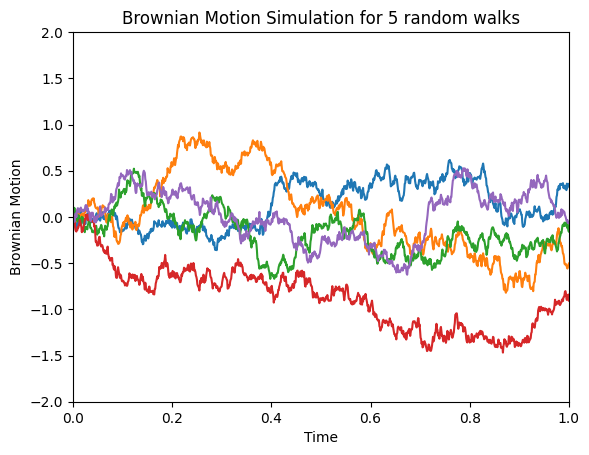

In [103]:
# Cell 2
# Plot of Brownian motion samples

for i in range(5):
  t, B_t = GBM(T=1.0, n=1000)
  plt.plot(t, B_t)

plt.xlabel("Time")
plt.ylabel("Brownian Motion")
plt.title("Brownian Motion Simulation for 5 random walks")
plt.xlim(0,1)
plt.ylim(-2,2)
plt.show()

In [104]:
# Cell 3
# Implement discrete version of our SDE

def SDE_sim(mu=.05, sigma=.3, S0=100, period=1.0, timesteps=10000):

    t, B_t = GBM(T=period, n=timesteps)

    S = np.zeros(timesteps + 1)
    S[0] = S0

    delta_t = period / timesteps
    for i in range(timesteps):
      delta_B = B_t[i+1] - B_t[i]
      S[i+1] = S[i] * np.exp((mu - 0.5 * sigma**2) * delta_t + sigma * delta_B)

    return t, S

<ipython-input-118-3761923467>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


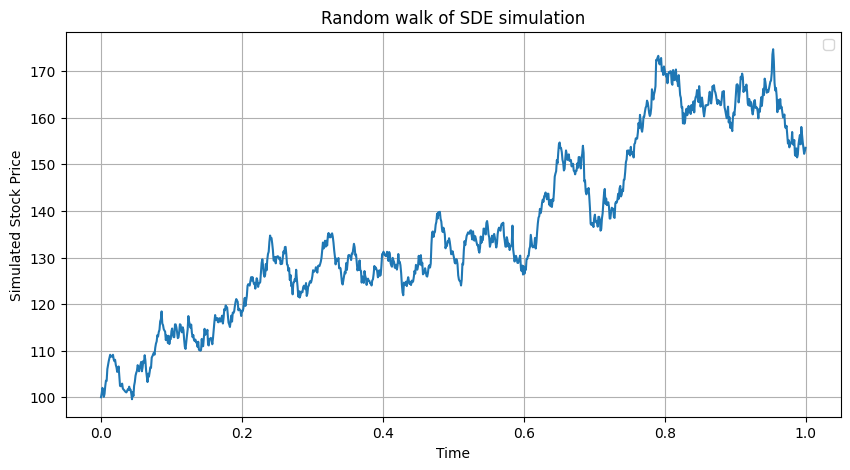

In [118]:
# Cell 5
# Graph of a sample SDE walk

mu=.15
sigma=.3
S0=100
period=1

t, S = SDE_sim(mu, sigma, S0, period, timesteps=1000)
plt.figure(figsize=(10, 5))
plt.plot(t, S)
plt.xlabel("Time")
plt.ylabel("Simulated Stock Price")
plt.title("Random walk of SDE simulation")
plt.grid(True)
plt.legend()
plt.show()

In [119]:
# Cell 6
# Generate data set

def make_dataset(num_samples, S0, period, timesteps):
  data = []
  targets = []
  for i in range(num_samples):
    mu = np.random.uniform(low=-0.15, high=0.15)
    sigma = np.random.uniform(low=0.02, high=0.3)
    t, S = SDE_sim(mu=mu, sigma=sigma, S0=S0, period=period, timesteps=timesteps)
    normalized_returns = np.diff(np.log(S))
    data.append(normalized_returns)
    targets.append([mu, sigma])

  return np.array(data), np.array(targets)

In [199]:
# Cell 7
# Create train test split
X, y = make_dataset(num_samples=1000, S0=100, period=1.0, timesteps=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [200]:
# Cell 8
# Make Neural Network

# input layer should be number of timesteps, i.e. however many subintervals the original interval T is partitioned into
def neural_network(timesteps, optimizer):
  model = Sequential()
  model.add(Dense(64, input_dim=timesteps, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(2, activation='linear'))

  model.compile(optimizer=optimizer, loss='mse')
  return model

NN_1 = neural_network(timesteps=100, optimizer='adam')
NN_2 = neural_network(timesteps=100, optimizer='sgd')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Cell 9
# Model tuning
epochs = [5, 10, 20, 50]
batchs = [16, 32, 64]
losses = []
for epoch in epochs:
  for batch in batchs:
    NN_1.fit(X_train, y_train, epochs=epoch, batch_size=batch, verbose=0)
    NN_2.fit(X_train, y_train, epochs=epoch, batch_size=batch, verbose=0)
    loss_adam = NN_1.evaluate(X_test, y_test)
    loss_sgd = NN_2.evaluate(X_test, y_test)
    losses.append((epoch, batch, loss_adam, loss_sgd))

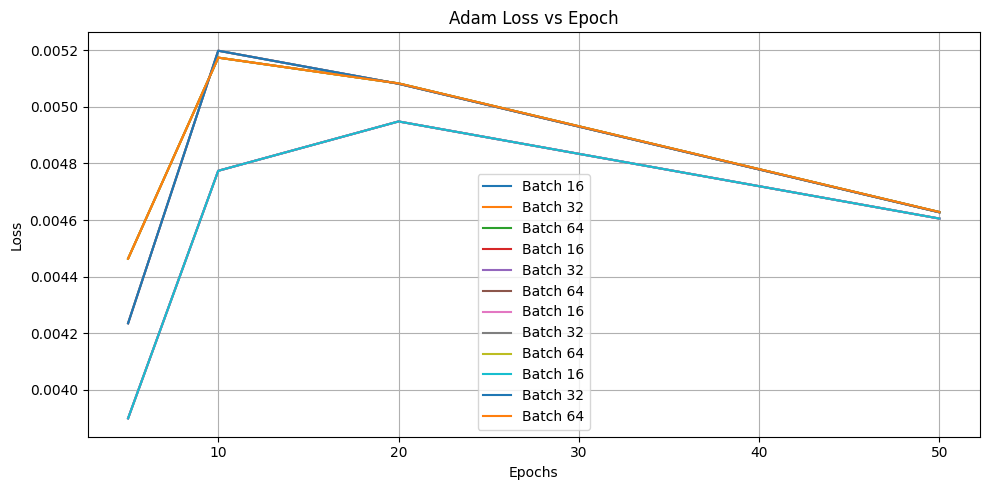

In [205]:
# Cell 10
# Plot loss of Adam
df = pd.DataFrame(losses, columns=['epoch', 'batch', 'loss_adam', 'loss_sgd'])

plt.figure(figsize=(10, 5))
for batch in df['batch']:
    subset = df[df['batch'] == batch]
    plt.plot(subset['epoch'], subset['loss_adam'], label=f'Batch {batch}')
plt.title('Adam Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

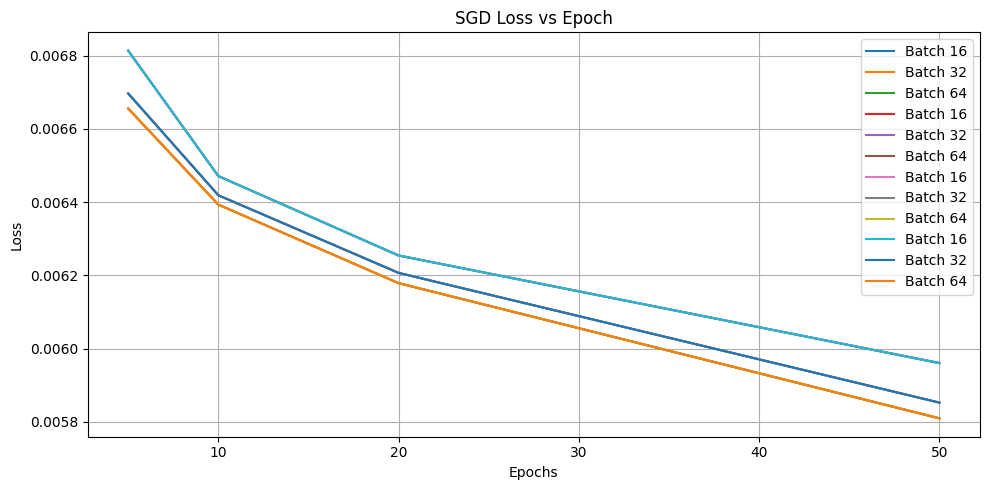

In [206]:
# Cell 11
# Plot loss of SGD
plt.figure(figsize=(10, 5))
for batch in df['batch']:
    subset = df[df['batch'] == batch]
    plt.plot(subset['epoch'], subset['loss_sgd'], label=f'Batch {batch}')
plt.title('SGD Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [212]:
# Cell 12
# Final Model
model = neural_network(timesteps=100, optimizer='sgd')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [213]:
# Cell 13
# Final Model RSME
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
RMSE: 0.0063


In [232]:
# Cell 14
# Testing on actual stock data

def stock_data(tkr='AAPL', interval = '1d'):

    data = yf.download(tkr, interval=interval)
    close_prices = data['Close'].iloc[:101]
    log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

    mu = log_returns.mean()
    sigma = log_returns.std()

    return log_returns, float(mu), float(sigma)

AAPL_returns, mu_actual, sigma_actual = stock_data()

prediction = model.predict(AAPL_returns.values.reshape(1, -1))

print(f"mu_actual: {mu_actual:.4f}")
print(f"mu_predicted: {prediction[0][0]:.4f}")

print(f"sigma_actual: {sigma_actual:.4f}")
print(f"sigma_predicted: {prediction[0][1]:.4f}")



[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
mu_actual: -0.0004
mu_predicted: -0.0184
sigma_actual: 0.0356
sigma_predicted: 0.1632



<ipython-input-232-3327753480>:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return log_returns, float(mu), float(sigma)
